<a href="https://colab.research.google.com/github/Raju1410/Class_IS532E/blob/main/GAN/CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Conditional GAN for Generating MNIST Handwritten Digits

In this example, we'll build a Conditional GAN (cGAN) that generates MNIST handwritten digits based on a given class label. This approach has several practical applications, especially in scenarios where you're dealing with an imbalanced image dataset.

- Instead of collecting additional data, which can be expensive and time-consuming, you can train a cGAN to generate new images for the underrepresented class. Since the generator is conditioned on class labels, it learns to create samples specific to each class.

- Additionally, the learned representations from the cGAN can be leveraged for other downstream tasks, such as improving classification models or boosting dataset diversity.


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

import keras
from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio

  Preparing metadata (setup.py) ... done


In [ ]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


### MNIST Dataset

- **Dataset Overview:**
  - **Total Images:** 70,000 images.
  - **Training Set:** 60,000 images.
  - **Test Set:** 10,000 images.
  - **Image Dimensions:** 28x28 pixels.
  - **Number of Classes:** 10 (digits 0 through 9).

  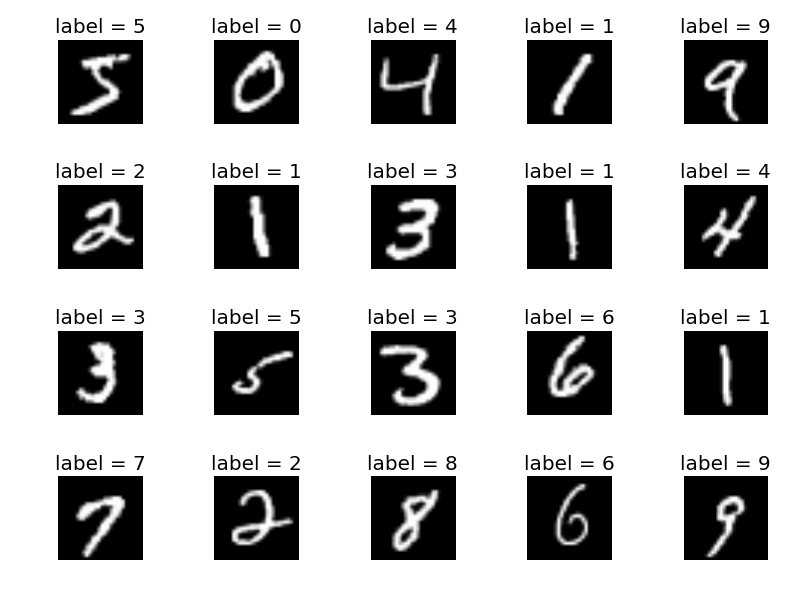

In [ ]:
# batch_size: The number of samples processed before the model's internal parameters are updated.
batch_size = 64

# num_channels: The number of color channels in the input images. For grayscale images, this is 1.
num_channels = 1

# num_classes: The number of different classes that the model needs to distinguish between.
num_classes = 10

# image_size: The height and width of the input images. Assuming square images, this is 28x28 pixels.
image_size = 28

# latent_dim: The dimensionality of the latent space in a model, often used in autoencoders or generative models.
latent_dim = 128

In [ ]:
# We'll use all the available examples from both the training and test
# sets.
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Load the MNIST dataset, which is split into training and test sets.

all_digits = np.concatenate([x_train, x_test])
# Concatenate the training and test images into a single array.

all_labels = np.concatenate([y_train, y_test])
# Concatenate the training and test labels into a single array.

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32") / 255.0
# Convert the pixel values from [0, 255] to [0, 1] by dividing by 255.0.

all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
# Reshape the images to add a channel dimension (28x28x1) for compatibility with convolutional layers.

all_labels = keras.utils.to_categorical(all_labels, 10)
# One-hot encode the labels to convert them into a binary matrix representation.

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
# Create a TensorFlow Dataset object from the concatenated images and labels.

dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
# Shuffle the dataset with a buffer size of 1024 and batch the data into batches of size 'batch_size'.

print(f"Shape of training images: {all_digits.shape}")
# Print the shape of the concatenated images array.

print(f"Shape of training labels: {all_labels.shape}")
# Print the shape of the concatenated labels array.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


## Calculating the number of input channel for the generator and discriminator

In [ ]:
# Calculate the number of input channels for the generator
generator_in_channels = latent_dim + num_classes
# The generator takes both a noise vector (latent_dim) and a class label (num_classes) as input.
# Therefore, the total number of input channels for the generator is the sum of the dimensionality of the latent space and the number of classes.

# Calculate the number of input channels for the discriminator
discriminator_in_channels = num_channels + num_classes
# The discriminator takes both the generated image (num_channels) and the class label (num_classes) as input.
# Therefore, the total number of input channels for the discriminator is the sum of the number of image channels and the number of classes.

# Print the number of input channels for the generator and discriminator
print(generator_in_channels, discriminator_in_channels)
# This line prints the calculated number of input channels for the generator and the discriminator.


138 11


## Generator

## Convolutional Neural Network Architecture
A CNN typically has three layers: a convolutional layer, a pooling layer, and a fully connected layer.
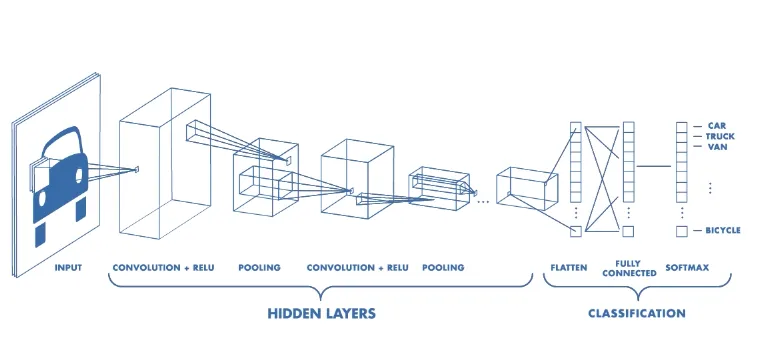
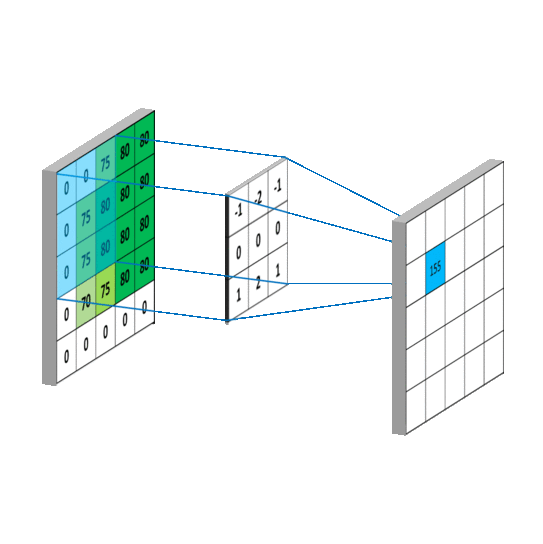

In [ ]:
# Create the generator.
generator = keras.Sequential(
    [
        # Input layer: Takes a noise vector of size (generator_in_channels,) as input.
        keras.layers.InputLayer((generator_in_channels,)),

        # Dense layer: Outputs 7 * 7 * generator_in_channels coefficients.
        layers.Dense(7 * 7 * generator_in_channels),

        # LeakyReLU activation function with a negative slope of 0.2.
        layers.LeakyReLU(negative_slope=0.2),

        # Reshape layer: Reshapes the output to a 7x7x(generator_in_channels) map.
        layers.Reshape((7, 7, generator_in_channels)),

        # First transposed convolutional layer: 128 filters, 4x4 kernel, 2x2 strides, same padding.
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),

        # LeakyReLU activation function with a negative slope of 0.2.
        layers.LeakyReLU(negative_slope=0.2),

        # Second transposed convolutional layer: 128 filters, 4x4 kernel, 2x2 strides, same padding.
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),

        # LeakyReLU activation function with a negative slope of 0.2.
        layers.LeakyReLU(negative_slope=0.2),

        # Final convolutional layer: 1 filter, 7x7 kernel, same padding, sigmoid activation.
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

# CNN visualization
https://poloclub.github.io/cnn-explainer/

In [ ]:
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6762)                │         939,918 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6762)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 138)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         282,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 1)           │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,491,215 (5.69 MB)

 Trainable params: 1,491,215 (5.69 MB)

 Non-trainable params: 0 (0.00 B)

## Discriminator

In [ ]:
# Create the discriminator.
discriminator = keras.Sequential(
    [
        # Input layer: Takes an image of size (28, 28, discriminator_in_channels) as input.
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),

        # First convolutional layer: 64 filters, 3x3 kernel, 2x2 strides, same padding.
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),

        # LeakyReLU activation function with a negative slope of 0.2.
        layers.LeakyReLU(negative_slope=0.2),

        # Second convolutional layer: 128 filters, 3x3 kernel, 2x2 strides, same padding.
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),

        # LeakyReLU activation function with a negative slope of 0.2.
        layers.LeakyReLU(negative_slope=0.2),

        # Global max pooling layer: Reduces the spatial dimensions to 1x1.
        layers.GlobalMaxPooling2D(),

        # Dense layer: Outputs a single value indicating whether the image is real or fake.
        layers.Dense(1),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │           6,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 80,385 (314.00 KB)

 Trainable params: 80,385 (314.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator  # Discriminator model
        self.generator = generator  # Generator model
        self.latent_dim = latent_dim  # Dimensionality of the latent space
        self.seed_generator = keras.random.SeedGenerator(1337)  # Seed generator for reproducibility
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")  # Tracker for generator loss
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")  # Tracker for discriminator loss

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker] # Return the loss trackers

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer  # Optimizer for the discriminator
        self.g_optimizer = g_optimizer  # Optimizer for the generator
        self.loss_fn = loss_fn          # Loss function

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [ ]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - d_loss: 0.4419 - g_loss: 1.4112
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step - d_loss: 0.5173 - g_loss: 1.2269
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - d_loss: 0.4051 - g_loss: 1.5432
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - d_loss: 0.2323 - g_loss: 2.1747
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.5810 - g_loss: 1.3034
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.6181 - g_loss: 1.0269
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - d_loss: 0.6476 - g_loss: 0.8960
Epoch 8/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - d_loss: 0.6520 - g_loss: 0.8659
Epoch 9/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - d_loss: 0.6521 - g_loss: 0.8888
Epoch 10/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - d_loss: 0.6638 - g_loss: 0.8243
Epoch 11/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 29s 26ms/step - d_loss: 0.6628 - g_loss: 0.8132
Epoch 12

In [ ]:
# We first extract the trained generator from our Conditional GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 50  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    # Calculate the interpolation vector between the two labels.
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 4  # @param {type:"slider", min:0, max:9, step:1}
end_class = 9  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step



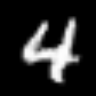

In [ ]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1)
embed.embed_file("animation.gif")